In [1]:
from __future__ import annotations
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import time
import matplotlib.pyplot as plt
from tkinter import *
from sklearn.decomposition import PCA
import torch

from rl.gh_config import Arguments, Config
from rl.gh_AgentSAC import AgentSAC
from rl.gh_net import GRUNetActor, GRUNetCritic, ActorSAC, CriticTwin
from env.gh_stockEnv import StockTradingEnvSeq
from processor.gh_processor_alpaca import AlpacaProcessor
from processor.gh_data_processor import DataProcessor
from rl.gh_run import init_buffer, init_evaluator

# Define config, create data processor

In [3]:
config = Config()
kwargs = {
    "API_KEY": config.ALPACA_API_KEY,
    "API_SECRET":config.ALPACA_API_SECRET,
    "API_BASE_URL":config.ALPACA_API_BASE_URL
}

dp = DataProcessor("alpaca", tech_indicator_list = config.INDICATORS, **kwargs)

Alpaca successfully connected


# Read and Manipulate Data

In [7]:
## read in data
df_train = pd.read_csv("./data/sp500_50_train.csv", index_col=0)
df_test = pd.read_csv("./data/sp500_50_test.csv", index_col=0)

In [5]:
## create functions to get lookback sequence
def get_sequential(data, lookback, gru):
    if not gru: return data

    data_list = []
    for i in range(len(data) - lookback +1):
        data_list.append(data.iloc[i:(i+lookback), :])

    return np.array(data_list).astype(np.float32)

## create function to prepare data
def prepare_data(df, lookback):
    ## turn open/close into a log difference in NEW COLUMNS
    df = df.copy()
    cols = ["open", "high", "low", "close"]
    for ticker in df["tic"].unique():
        temp = np.log(df.loc[df["tic"] == ticker, cols])
        temp.columns = [i + "_diff" for i in cols]
        df.loc[df["tic"] == ticker, [i + "_diff" for i in cols]] = temp - temp.shift(1)

    ## drop NA values caused by differencing, ffill with fillna, and drop na across indicators
    df = df.dropna(subset = ["open_diff", "high_diff", "low_diff", "close_diff"])
    df[config.INDICATORS] = df[config.INDICATORS].fillna(method="ffill")
    df = df.dropna()

    ## get unscaled, unpivoted data
    actual_price_array, actual_tech_array, actual_turbulence_array = dp.df_to_array(df, True)

    ## pivot data
    df = df.pivot(index = "timestamp", columns = "tic")
    df.columns = [col[1] + "_" + col[0] for col in df.columns]

    ## get column names for standardization
    cols = ["volume", "trade_count", "VIXY", "open", "high", "close", "low"] + config.INDICATORS
    rgx = "(" + "|".join([i for i in cols]) + ")$"
    all_cols = df.filter(regex=rgx).columns

    ## standardize data
    scaler = StandardScaler().fit(df[all_cols])
    df[all_cols] = pd.DataFrame(scaler.transform(df[all_cols]), index=df[all_cols].index, columns=df[all_cols].columns)

    ## get time data
    df = df.reset_index()
    df["time"] = pd.to_datetime(df["timestamp"]).apply(lambda x: 60*x.time().hour + x.time().minute)
    df["weekday"] = pd.to_datetime(df["timestamp"]).apply(lambda x: x.weekday())

    df["time_sin"] = df[["time"]].apply(lambda x: np.sin((2*np.pi*x)/x.max()))
    df["time_cos"] = df[["time"]].apply(lambda x: np.cos((2*np.pi*x)/x.max()))
    df["weekday_sin"] =df[["weekday"]].apply(lambda x: np.sin((2*np.pi*x)/x.max()))
    df["weekday_cos"] = df[["weekday"]].apply(lambda x: np.cos((2*np.pi*x)/x.max()))

    df = df.drop(columns=["time", "weekday", "timestamp"])

    ## get data as three seperate data frames
    tech_rgx = "(" + "|".join(config.INDICATORS + ["time_sin", "time_cos", "weekday_sin", "weekday_cos"]) + ")$"
    df_tech = df.filter(regex = tech_rgx)
    df_price = df.filter(regex = "(timestamp|close)$")
    df_turb = pd.DataFrame(df.filter(regex = "VIXY$").apply(lambda x: np.unique(x)[0], axis = 1))

    return df_price, df_tech, df_turb, actual_price_array


def get_data_seq(train, test, lookback, pca_components, gru=True):
    ## get train and test data
    df_price_train, df_tech_train, df_turb_train, actual_price_array_train = prepare_data(train, lookback)
    df_price_test, df_tech_test, df_turb_test, actual_price_array_test = prepare_data(test, lookback)

    ## use to PCA to decrease dimensionality of tech data
    pca = PCA(n_components=pca_components)
    tickers = np.unique([col.split("_")[0] for col in df_tech_train.filter(regex="(" + "|".join(config.INDICATORS) + ")$").columns])
    df_pca_train, df_pca_test = pd.DataFrame(),  pd.DataFrame()
    
    for tic in tickers:
        tic_df_train, tic_df_test = df_tech_train.filter(regex = "^" + tic), df_tech_test.filter(regex = "^" + tic)
        temp_pca = pca.fit(tic_df_train)

        pca_cols = [tic+"_tech_" + str(i + 1) for i in range(pca_components)]
        df_pca_train[pca_cols] = temp_pca.transform(tic_df_train)
        df_pca_test[pca_cols] = temp_pca.transform(tic_df_test)
            
        # df_pca_train[[tic+"_tech_1", tic+"_tech_2"]] = temp_pca.transform(tic_df_train)
        # df_pca_test[[tic+"_tech_1", tic+"_tech_2"]] = temp_pca.transform(tic_df_test)

    df_pca_train.loc[:, ["time_sin", "time_cos", "weekday_sin", "weekday_cos"]] = df_tech_train.loc[:, ["time_sin", "time_cos", "weekday_sin", "weekday_cos"]]
    df_pca_test.loc[:, ["time_sin", "time_cos", "weekday_sin", "weekday_cos"]] = df_tech_test.loc[:, ["time_sin", "time_cos", "weekday_sin", "weekday_cos"]]

    ## get sequential data from dataframes
    seq_price_array_train = get_sequential(df_price_train, lookback, gru)
    seq_tech_array_train = get_sequential(df_pca_train, lookback, gru)
    seq_turb_array_train = get_sequential(df_turb_train, lookback, gru)

    seq_price_array_test = get_sequential(df_price_test, lookback, gru)
    seq_tech_array_test = get_sequential(df_pca_test, lookback, gru)
    seq_turb_array_test = get_sequential(df_turb_test, lookback, gru)

    return seq_price_array_train, seq_tech_array_train, seq_turb_array_train, actual_price_array_train,\
                seq_price_array_test, seq_tech_array_test, seq_turb_array_test, actual_price_array_test

In [6]:
## get data in correct format with deired lookback and PCA components
seq_price_array, seq_tech_array, seq_turb_array, actual_price_array, seq_price_array_tst,\
    seq_tech_array_tst, seq_turb_array_tst, actual_price_array_tst = get_data_seq(df_train, df_test, lookback=1, pca_components=2)

Successfully transformed into array
Successfully transformed into array


# Modeling

In [7]:
## FOR SEQUENTIAL DATA
env_config = {
        "seq_price_array": seq_price_array,
        "seq_tech_array": seq_tech_array,
        "seq_turb_array": seq_turb_array,
        "actual_price_array":actual_price_array,
        "if_train": True,
        "reward_scaling":1,
        "lookback":1,
        "max_amount_rate": 1#,
        #"min_amount_rate": .05
    }
stock_env = StockTradingEnvSeq(**env_config)

## create argument for actor/critic network
# actor_args = {
#     "hidden_dim1": 170, ## changed from 90
#     "hidden_dim2": 130,
#     "hidden_dim3": 90,
#     "mid_dim": 70, ## lowered from 60
#     "n_layers": 3,
#     "drop_prob": .2,
# }

## create dictionaries for actor/critic network
# actor_args = {
#     "layers": [100, 100],
#     "avg_layers": [100],
#     "std_layers": [100]
# }
# critic_args = {
#     "layers": [100, 100],
#     "q_layers": [100]
# }
actor_args = {
    "mid_dim": 100,
    "num_layer": 3
}

## setting eval_steps = stock_env.max_step SHOULD let us evaluate after every full pass through the data
args = Arguments(
    env = stock_env,
    lookback = env_config["lookback"],
    agent_class = AgentSAC,
    actor_args = actor_args,
    #critic_args = critic_args,
    break_step = stock_env.max_step*3, #500000,
    eval_steps = stock_env.max_step,
    cwd = "./models/SAC_lb_1_pca2_lin_100_buffer_1e3_max_1TEST", ## SAC_lb_{lookback #}_pca_{pca #}_{hidden_dim}_{mid_dim}
    act_class = ActorSAC, # GRUNetActor,
    cri_class = CriticTwin, # GRUNetCritic,
    max_memo = 1e3)

In [7]:
## create function to train model
def train_and_evaluate(args):
    """
    The training and evaluating loop.

    :param args: an object of ``Arguments`` class, which contains all hyper-parameters.
    """
    torch.set_grad_enabled(False)
    args.init_before_training()
    gpu = args.gpu

    '''init'''
    env = args.env
    #agent = elegantrl.train.run.init_agent(args, gpu, env)
    agent = args.agent_class(args.action_dim, args.state_dim, args.actor_args, args.critic_args, gpu, args)
    state = env.reset()
    states = [state, ]
    agent.states = states
    
    buffer = init_buffer(args, gpu)
    evaluator = init_evaluator(args, gpu)
    agent.state = env.reset()
    if args.if_off_policy:
        trajectory, done = agent.explore_env(env, args.max_memo, done = False)
        #trajectory, done = agent.explore_env(env, args.num_seed_steps * args.num_steps_per_episode, done = False)
        buffer.update_buffer(trajectory)
        evaluator.total_step += args.max_memo

    '''start training'''
    cwd = args.cwd
    break_step = args.break_step
    horizon_len = args.horizon_len
    if_allow_break = args.if_allow_break
    if_off_policy = args.if_off_policy
    #del args
    if_train, done = True, False

    eval_config = {
        "seq_price_array": seq_price_array_tst,
        "seq_tech_array": seq_tech_array_tst,
        "seq_turb_array": seq_turb_array_tst,
        "actual_price_array":actual_price_array_tst,
        "if_train": False,
        "reward_scaling":env.reward_scaling,
        "lookback":env.lookback
    }

    while if_train:
        trajectory, done = agent.explore_env(env, horizon_len, done)
        if if_off_policy:
            _, r_exp = buffer.update_buffer(trajectory)
            torch.set_grad_enabled(True)
            logging_tuple = agent.update_net(buffer)
            torch.set_grad_enabled(False)
        else:
            r_exp = trajectory[3].mean().item()
            torch.set_grad_enabled(True)
            logging_tuple = agent.update_net(trajectory)
            torch.set_grad_enabled(False)
            
        (if_reach_goal, if_save) = evaluator.evaluate_save_and_plot(agent.act, horizon_len, r_exp, logging_tuple, eval_config)
        dont_break = not if_allow_break
        not_reached_goal = not if_reach_goal
        stop_dir_absent = not os.path.exists(f"{cwd}/stop")
        if_train = (
                (dont_break or not_reached_goal)
                and evaluator.total_step <= break_step
                and stop_dir_absent
        )
    print(f'| UsedTime: {time.time() - evaluator.start_time:.0f} | SavedDir: {cwd}')

    agent.save_or_load_agent(cwd, if_save=True)
    return evaluator

In [8]:
evaluator = train_and_evaluate(args)

| Arguments Keep cwd: ./models/SAC_lb_1_pca2_lin_100_buffer_1e3_max_1TEST
################################################################################
ID     Step    maxR    test_return |    avgR   stdR   avgS  stdS |    expR   objC   etc.
0  1.67e+04  267.46 |
0  1.67e+04  267.46        1.43547 |  267.46   12.4  16651     0 |    2.60  56.38  36.97   0.04
0  3.33e+04  271.15 |
0  3.33e+04  271.15        1.42558 |  271.15   10.7  16651     0 |    2.6139722.62 519.47   0.48
0  5.00e+04  271.15        1.42528 |  268.15   16.7  16651     0 |    2.6114532105.004868.57   6.52
| UsedTime: 89 | SavedDir: ./models/SAC_lb_1_pca2_lin_100_buffer_1e3_max_1TEST


In [8]:
## evaluate performance on test data
agent = AgentSAC(args.action_dim, args.state_dim, args.actor_args, args.critic_args, args.gpu, args)
agent.save_or_load_agent(cwd=args.cwd, if_save=False)

env_config = {
        "seq_price_array": seq_price_array_tst,
        "seq_tech_array": seq_tech_array_tst,
        "seq_turb_array": seq_turb_array_tst,
        "actual_price_array":actual_price_array_tst,
        "if_train": False,
        "reward_scaling":args.env.reward_scaling,
        "lookback":args.lookback

    }
env = StockTradingEnvSeq(**env_config)

state = env.reset()
episode_reward = 0
episode_total_assets = []
episode_returns = []

for i in range(env.max_step):

    tensor_state = torch.as_tensor(state, dtype=torch.float32) #.unsqueeze(0)
    tensor_action = agent.act.forward(tensor_state.to(agent.device)).detach().cpu().flatten()  # different
    next_state, reward, done, _ = env.step(tensor_action.numpy())

    #total_asset = env.amount + (env.actual_price_array[env.day] * env.stocks).sum()
    episode_total_assets.append(env.total_asset[-1,0])
    episode_returns.append(env.total_asset[-1,0] / env.initial_total_asset)
    
    episode_reward += reward
    if done:
        print(f'Step {i:>6}, Episode reward {episode_reward:8.3f}')
        break
    else:
        state = next_state

Step   3273, Episode reward   45.024


<AxesSubplot: >

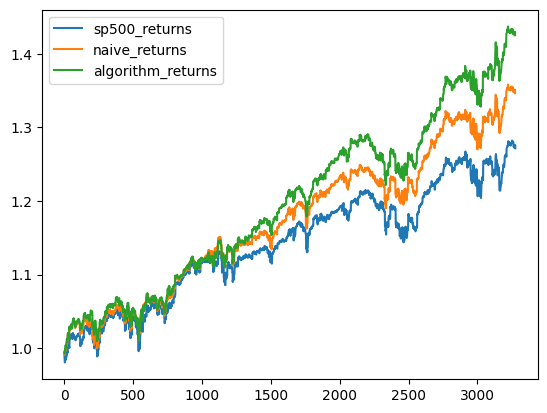

In [9]:
stock_df = pd.DataFrame(actual_price_array_tst[1:]).apply(lambda x: 1/50*(x / x[0])).apply(lambda x: x.sum(), axis = 1)
voo_df = pd.read_csv("./data/VOO_test_df.csv", index_col=0)[2:]

voo_df = voo_df.rename(columns = {"return":"sp500_returns"})
voo_df["algorithm_returns"] = pd.Series(episode_returns)
voo_df["naive_returns"] = stock_df
voo_df[["sp500_returns", "naive_returns", "algorithm_returns"]].plot()

<AxesSubplot: >

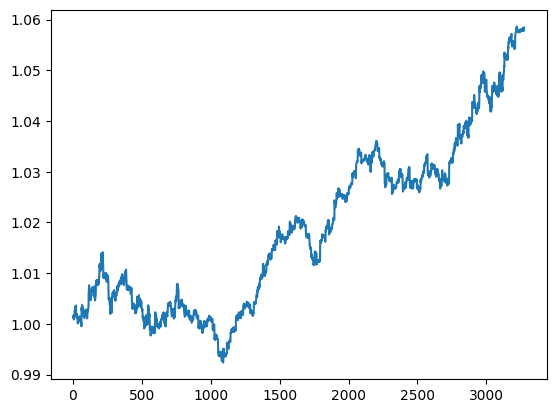

In [10]:
## plot how much better the returns are for the algorithm vs. a naive even investment
(voo_df["algorithm_returns"] / voo_df["naive_returns"]).plot()